# Load Libraries and Functions

In [66]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Importing Custom Functions
import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years, examine_text_outliers
from Functions import process_company_text, clean_manufacturer_text, clean_data, list_to_string


ImportError: cannot import name 'list_to_string' from 'Functions' (Functions.ipynb)

### Test Multiprocessing with Script

In [2]:
def f(x):
    return x*x

# should add if __name__ == '__main__': protection to protect against infinite process creation
if __name__ == '__main__':
    with mp.Pool(5) as pool:
        print(pool.map(f, [1, 2, 3, 4, 5]))

[1, 4, 9, 16, 25]


# API Keys and Passwords

In [3]:
# MySQL password
PASSWORD = "PASSWORD"  # Your Password

# openFDA API Key
openFDAAPI = "E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk"  # Halee

# Data.Medicaid API Key

In [4]:
# Code to assess performance
# Still need to implement
#from line_profiler import LineProfiler

#def your_function():
    # Your code here


#profiler.add_function(your_function)
#profiler.run('your_function()')
#profiler.print_stats()

# FDA Data

## API Request for Historical Text Documents
* From Year of FAERS Inception until Most Recent

https://open.fda.gov/apis/other/historicaldocument/

In [5]:
# Time API call
start_time = time.time() 

# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0,       # Starting point for fetching records
    'search': "year:2012 + year:2013 + year:2014"
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    documents = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        pause_execution()

        print('.', end='', flush=True)

    return documents

# Fetch the data
documents = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")


.Failed to fetch data: 404

Request Time: 1.4345569610595703


In [6]:
# Save the data to a dataframe
documents_df = pd.DataFrame(documents)
documents_df.head()

,doc_type,year,text
0,pr,2014,FDA NEWS RELEASE\nFor Immediate Release: April...
1,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...
2,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
3,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
4,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...


In [7]:
# 8854 documents at time of project creation
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  484 non-null    object
 1   year      484 non-null    int64 
 2   text      484 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.5+ KB


In [8]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [9]:
# Time the API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
params = {
    'limit': 100,  # Maximum limit per request
    'search': '_exists_:patient.reaction.reactionoutcome AND primarysource.qualification:<4 AND patient.reaction.reactionoutcome:<6 AND _exists_:patient.patientweight AND receiptdate:[2020-01-01 TO 2024-04-23]',
}

# Output file path outside of GitHub due to large file size
# Create local path in downloads for data
OUTPUT_FILE = os.path.join(os.environ['USERPROFILE'], 'Downloads', 'drug_events.csv')


# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())


# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0

    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True

        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }

            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)

            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break

            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break

            # Convert the results to a DataFrame
            df = pd.DataFrame(results)

            # Write the data to CSV incrementally
            if first_chunk:
                df.to_csv(file, index=False, mode='a')
                first_chunk = False
            else:
                df.to_csv(file, index=False, header=False, mode='a')

            count += len(results)

            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break

            if not next_url:
                print("No more pages found.")
                break

            pause_execution()
            print('.', end='', flush=True)

    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE


# Fetch the data and save it incrementally to a CSV file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

KeyError: 'USERPROFILE'

In [ ]:
events_df = pd.read_csv('C:\\Users\halee\Downloads\drug_events.csv')

In [ ]:
events_df = pd.read_csv('C:\\Users\halee\Downloads\drug_events.csv')

In [ ]:
events_df.head()

In [ ]:
events_df.shape

In [ ]:
nan_info(events_df)

In [ ]:
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [11]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0,      # Starting point for fetching records
    #'search': 'effective_time:[2023-06-01 TO 2023-12-31]'
    'search': 'effective_time:[2023-12-30 TO 2023-12-31]'

}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_all_data():
    labels = []
    request_count = 0  # Initialize request counter
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
  
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            labels.append(item)
        
        params['skip'] += params['limit']
        request_count += 1  # Increment request counter
        pause_execution()
        
        print('.', end='', flush=True)

    return labels

# Fetch the data
labels = fetch_all_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time: {execution_time}")
print(f"Total records fetched: {len(labels)}")

.Failed to fetch data: 404
Request Time: 11.939393043518066
Total records fetched: 225


In [12]:
# Convert the data to a pandas DataFrame
labels_df = pd.json_normalize(labels)

# Display the first few rows of the DataFrame
labels_df.head()

,spl_product_data_elements,active_ingredient,purpose,indications_and_usage,warnings,when_using,keep_out_of_reach_of_children,dosage_and_administration,inactive_ingredient,package_label_principal_display_panel,...,indications_and_usage_table,boxed_warning_table,pharmacodynamics_table,openfda.original_packager_product_ndc,drug_abuse_and_dependence_table,controlled_substance,abuse,abuse_table,dependence,active_ingredient_table
0,[CeraVe Developed with Dermatologists Acne Con...,[Active ingredient Salicylic acid 2%],[Purpose Acne treatment],[Uses clears acne blemishes and allows skin to...,[Warnings For external use only],[When using this product skin irritation and d...,"[Keep out of reach of children. If swallowed, ...","[Directions use twice daily shake well, wet fa...","[Inactive ingredients water, sodium lauroyl sa...","[image of a label, image of a label]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Lancome Paris High Resolution Refill 3X Tripl...,[Active ingredients Avobenzone 3% Octisalate 5...,[Purpose Sunscreen],[Uses - helps prevent sunburn - if used as dir...,[Warnings For external use only],[When using this product keep out of eyes. Rin...,"[Keep out of reach of children. If swallowed, ...",[Directions For sunscreen use: ● apply generou...,"[Inactive ingredients water, glycerin, dimethi...",[image of a label],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Coppertone EveryTone Face Sunscreen SPF 55 Av...,"[Active ingredients Avobenzone 3%, Homosalate ...",[Purpose Sunscreen],[Use ■ helps prevent sunburn],[Warnings For external use only],[When using this product keep out of eyes. Rin...,[Keep out of reach of children. If product is ...,[Directions ■ apply liberally 15 minutes befor...,"[Inactive ingredients dicaprylyl carbonate, bu...",[Coppertone ® Clear Sunscreen EveryTone Invisi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Kiehls Since 1851 Activated Sun Protector Bro...,[Active ingredient Avobenzone 3% Homosalate 10...,[Purpose Sunscreen],[Uses helps prevent sunburn if used as directe...,[Warnings For external use only],[When using this product keep out of eyes. Rin...,"[Keep out of reach of children. If swallowed, ...",[Directions For sunscreen use: ● apply liberal...,"[Inactive ingredients water, dimethicone, alco...",[image of a label],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[La Roche Posay Laboratoire Dermatologique Ant...,[Active ingredient Avobenzone 3% Homosalate 15...,[Purpose Sunscreen],[Uses helps prevent sunburn if used as directe...,[Warnings For external use only],[When using this product keep out of eyes. Rin...,"[Keep out of reach of children. If swallowed, ...",[Directions For sunscreen use: ● apply generou...,"[Inactive ingredients water, silica, dicapryly...",[image description],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
pd.set_option('display.max_info_columns', 160)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 107 columns):
 #    Column                                                      Non-Null Count  Dtype 
---   ------                                                      --------------  ----- 
 0    spl_product_data_elements                                   225 non-null    object
 1    active_ingredient                                           169 non-null    object
 2    purpose                                                     149 non-null    object
 3    indications_and_usage                                       209 non-null    object
 4    warnings                                                    201 non-null    object
 5    when_using                                                  118 non-null    object
 6    keep_out_of_reach_of_children                               153 non-null    object
 7    dosage_and_administration                                   225 non-null    object
 8  

In [ ]:
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Manufacturer Information (NDC)

In [ ]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug data
BASE_URL = 'https://api.fda.gov/drug/ndc.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    manus = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            manus.append(item)
        
        params['skip'] += params['limit']
        pause_execution()
        
        print('.', end='', flush=True)

    return manus

# Fetch the data
manus = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")

In [ ]:
# Convert the data to a pandas DataFrame
manus_df = pd.json_normalize(manus)

# Display the first few rows of the DataFrame
manus_df.head()

In [ ]:
pd.set_option('display.max_info_columns', 40)
manus_df.info()

In [ ]:
manus_df.shape

## Historical Drug Record - not useful

In [ ]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching dru data
BASE_URL = 'https://api.fda.gov/drug/drugsfda.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Maximum limit per request
    'skip': 0      # Starting point for fetching records
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    hist_drugs = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)
        #print(f"Requesting data with params: {params}")  # Debugging statement
        #print(f"Response status code: {response.status_code}")  # Debugging statement

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")  # Debugging statement
            break

        for item in results:
            hist_drugs.append(item)
        
        params['skip'] += params['limit']
        pause_execution()
        
        print('.', end='', flush=True)

    return hist_drugs

# Fetch the data
hist_drugs = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")

In [ ]:
# Convert the data to a pandas DataFrame
hist_df = pd.json_normalize(hist_drugs)

# Display the first few rows of the DataFrame
hist_df.head()

In [ ]:
hist_df.info()

# National Library of Medicine - Standardized Drug Names and Information

## Function below calls all matches based on all ndc/setid/rxcui from a dataframe, need to create one that essentially finds only missing values only to reduce comp. time. Logic: 
* Find which one of the index variables has the least amount of missing data in table (rxcui, set id, ndc code)
* Check what corresponding variables are missing 
* Call API to get matching data for those values
* Replace missing values based on logic with retrieved data
* Add NDC11 format to all tables to match with prices, or remove last two characters from NDC11 in prices table so string will match with ndc9 or ndc10

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [25]:
# Function to fetch NDC properties one at a time
def fetch_ndc_properties(var_list):
    url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    headers = {"Accept": "application/json"}

    ndc_properties = []
    rxcui_result = []
    processed_rxcuis = set()  # Set to track processed rxcuis
    
    # Choose variable with the highest amount of records to get most matches
    for var in var_list:  # Can be rxcui, ndc codes, or spl set IDS, choose one
        
        # Might need to update this part
        # Loop is slowing down processing
        # Removing duplicates at end might be sufficient (already coded below)
        if var in processed_rxcuis:
            #print(f"Skipping already processed rxcui: {var}")
            continue  # Skip if already processed

        params = {"id": var}  # Single code

        try:
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()  # Raise an error for bad status codes
            data = response.json()
            properties = data.get("ndcPropertyList", {}).get("ndcProperty", [])

            if not properties:
                continue
                #print(f"No properties found for rxcui: {var}")

            # Filter the required fields
            for item in properties:
                filtered_property = {
                    'ndcItem': item.get('ndcItem'),  # NDC 11 format
                    'ndc9': item.get('ndc9'),
                    'ndc10': item.get('ndc10'),
                    'rxcui': item.get('rxcui'),
                    'splSetIdItem': item.get('splSetIdItem')
                }
                ndc_properties.append(filtered_property)
                rxcui_result.append(item.get('rxcui'))

            # Mark the rxcui as processed
            processed_rxcuis.add(var)

            # Adding a delay to respect the rate limit with randomness
            time.sleep(1 / 18 + 0.1 * random.random())  # 18 requests per second with additional randomness

        except requests.exceptions.RequestException as e:
            #print(f"Request failed for rxcui: {var}, Error: {e}")
            continue  # Skip to the next rxcui if there's an error

        print(f'.', end='', flush=True )

    # Convert to DataFrame
    df_ndc_properties = pd.json_normalize(ndc_properties)
    # Retain only the first instance of each ndc9
    df_cleaned = df_ndc_properties.drop_duplicates(subset='ndc9', keep='first')
    return df_cleaned, rxcui_result

In [26]:
# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [ ]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

In [ ]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

In [ ]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

# Medicaid 

## API Drug Prices - NADAC - 2024 Report 

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [ ]:
# Time API Call
start_time = time.time()

# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time 
    time.sleep(1/10 + 0.1 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    
    while True:  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        #print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        #print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            #print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
            print('.', end='', flush=True)
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time: {execution_time}")

### Get more years to align with FAERS data years?

In [ ]:
# 2023

In [ ]:
# 2022

In [ ]:
# 2021

In [ ]:
# 2020

In [ ]:
# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()

In [ ]:
prices_df.info()

# Preprocessing

## PreProcess Labels Table

#### Select Columns

In [14]:
labels_table = pd.DataFrame(labels_df, 
                            columns = ["set_id",  # globally unique identifier (GUID) for the labeling
                                       "effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       #"spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        "active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.unii",  # Unique ingredient, do not tokenize
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [15]:
labels_table.head()

,set_id,effective_time,purpose,warnings,active_ingredient,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00203b2a-74dd-45a5-977a-3ef4eb314577,20231231,[Purpose Acne treatment],[Warnings For external use only],[Active ingredient Salicylic acid 2%],[CeraVe Developed with Dermatologists Acne Con...,[SALICYLIC ACID],[L'Oreal USA Products Inc],[SALICYLIC ACID],[O414PZ4LPZ],[49967-138],[562600],NaN,NaN
1,02c51b56-e39a-4b3b-88c6-b7dc9c165f7e,20231230,[Purpose Sunscreen],[Warnings For external use only],[Active ingredients Avobenzone 3% Octisalate 5...,[Lancome Paris High Resolution Refill 3X Tripl...,"[AVOBENZONE, OCTISALATE AND OCTOCRYLENE]",[L'Oreal USA Products Inc],"[AVOBENZONE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, 4X49Y0596W, 5A68WGF6WM]",[49967-502],NaN,NaN,NaN
2,04b12f39-778c-ecee-e063-6394a90afa24,20231230,[Purpose Sunscreen],[Warnings For external use only],"[Active ingredients Avobenzone 3%, Homosalate ...",[Coppertone EveryTone Face Sunscreen SPF 55],"[AVOBENZONE 3%, HOMOSALATE 15%, OCTISALATE 5%,...",[Beiersdorf Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6WM]",[66800-1094],NaN,NaN,NaN
3,04fd0839-5046-4633-a919-6b7b6bea4f3e,20231230,[Purpose Sunscreen],[Warnings For external use only],[Active ingredient Avobenzone 3% Homosalate 10...,[Kiehls Since 1851 Activated Sun Protector Bro...,"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLE...",[L'Oreal USA Products Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLE...","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6W...",[49967-047],NaN,NaN,NaN
4,06f2ced8-273e-454f-92b4-2846f6674b37,20231231,[Purpose Sunscreen],[Warnings For external use only],[Active ingredient Avobenzone 3% Homosalate 15...,[La Roche Posay Laboratoire Dermatologique Ant...,"[AVOBENZONE, HOMOSALATE, OCTISALATE AND OCTOCR...",[L'Oreal USA Products Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6WM]",[49967-994],NaN,NaN,NaN


## LIST OF UNIQUE DRUG NAMES

In [16]:
# ADDED TO FUNCTIONS file

# drugs are currently in list format, clean to work with
def clean_data(x):
    if isinstance(x, list):
        return ','.join(x)
    elif isinstance(x, str):
        return x  # Handle strings as needed
    else:
        return x  # Handle other types as needed

# match text
def contains_unique_value(text, unique_values_lower):
    matched_texts = []
    text_lower = text.lower()
    for value in unique_values_lower:
        if value in text_lower:
            matched_texts.append(value)
    return matched_texts

### No multiprocessing

In [17]:
start_time = time.time() 
labels_table['openfda.brand_name'] = clean_data(labels_table['openfda.brand_name'])
labels_table['openfda.generic_name'] = clean_data(labels_table['openfda.generic_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.0048410892486572266


### Use multiprocessing

In [18]:
start_time = time.time() 

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        openfda_brand_name = pool.map(clean_data, labels_table['openfda.brand_name'])
        openfda_generic_name = pool.map(clean_data, labels_table['openfda.generic_name'])
    labels_table['openfda.brand_name'] = openfda_brand_name
    labels_table['openfda.generic_name'] = openfda_generic_name

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.1907038688659668


In [19]:
labels_table.head()

,set_id,effective_time,purpose,warnings,active_ingredient,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00203b2a-74dd-45a5-977a-3ef4eb314577,20231231,[Purpose Acne treatment],[Warnings For external use only],[Active ingredient Salicylic acid 2%],CeraVe Developed with Dermatologists Acne Cont...,SALICYLIC ACID,[L'Oreal USA Products Inc],[SALICYLIC ACID],[O414PZ4LPZ],[49967-138],[562600],NaN,NaN
1,02c51b56-e39a-4b3b-88c6-b7dc9c165f7e,20231230,[Purpose Sunscreen],[Warnings For external use only],[Active ingredients Avobenzone 3% Octisalate 5...,Lancome Paris High Resolution Refill 3X Triple...,"AVOBENZONE, OCTISALATE AND OCTOCRYLENE",[L'Oreal USA Products Inc],"[AVOBENZONE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, 4X49Y0596W, 5A68WGF6WM]",[49967-502],NaN,NaN,NaN
2,04b12f39-778c-ecee-e063-6394a90afa24,20231230,[Purpose Sunscreen],[Warnings For external use only],"[Active ingredients Avobenzone 3%, Homosalate ...",Coppertone EveryTone Face Sunscreen SPF 55,"AVOBENZONE 3%, HOMOSALATE 15%, OCTISALATE 5%, ...",[Beiersdorf Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6WM]",[66800-1094],NaN,NaN,NaN
3,04fd0839-5046-4633-a919-6b7b6bea4f3e,20231230,[Purpose Sunscreen],[Warnings For external use only],[Active ingredient Avobenzone 3% Homosalate 10...,Kiehls Since 1851 Activated Sun Protector Broa...,"AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLEN...",[L'Oreal USA Products Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLE...","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6W...",[49967-047],NaN,NaN,NaN
4,06f2ced8-273e-454f-92b4-2846f6674b37,20231231,[Purpose Sunscreen],[Warnings For external use only],[Active ingredient Avobenzone 3% Homosalate 15...,La Roche Posay Laboratoire Dermatologique Anth...,"AVOBENZONE, HOMOSALATE, OCTISALATE AND OCTOCRY...",[L'Oreal USA Products Inc],"[AVOBENZONE, HOMOSALATE, OCTISALATE, OCTOCRYLENE]","[G63QQF2NOX, V06SV4M95S, 4X49Y0596W, 5A68WGF6WM]",[49967-994],NaN,NaN,NaN


Extract unique list values

In [20]:
# extract unique list values
unique_brand_names = labels_table['openfda.brand_name'].dropna().unique()
unique_generic_names = labels_table['openfda.generic_name'].dropna().unique()

# combine the brand and generic columns to account for all possibl enames
unique_drug_names = set(unique_brand_names).union(set(unique_generic_names))

# convert to lowercase, could probably just add to clean data function
unique_drug_names = [str(value).lower() for value in unique_drug_names]

### Examine Nulls

In [21]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,set_id,0,0.000000
1,effective_time,0,0.000000
2,purpose,76,33.777778
3,warnings,24,10.666667
4,active_ingredient,56,24.888889
5,openfda.brand_name,44,19.555556
6,openfda.generic_name,44,19.555556
7,openfda.manufacturer_name,44,19.555556
8,openfda.substance_name,46,20.444444
9,openfda.unii,46,20.444444


In [22]:
labels_table.shape

(225, 14)

### Fill in NA values with RxNorm API Request

In [27]:
df_cleaned, rxcui_result = fetch_ndc_properties(labels_table['set_id'])
df_cleaned.shape

................................................................................................................

(190, 5)

In [37]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,set_id,0,0.000000
1,effective_time,0,0.000000
2,purpose,0,0.000000
3,warnings,0,0.000000
4,active_ingredient,0,0.000000
5,openfda.brand_name,0,0.000000
6,openfda.generic_name,0,0.000000
7,openfda.manufacturer_name,0,0.000000
8,openfda.substance_name,0,0.000000
9,openfda.unii,46,20.444444


### Fix Dtypes

In [29]:
# Update label date
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

# Add year column
labels_table['year'] = labels_table['effective_time'].dt.year

### Process Text Columns

In [30]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'set_id',
                                      'openfda.product_ndc', 
                                      'openfda.rxcui', 
                                      'openfda.unii'], 
                                     errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

## No MultiProcessing

In [40]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
start_time = time.time()

for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

1.824470043182373


## MultiProcessing

In [41]:
start_time = time.time()

if __name__ == '__main__':
     with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            labels_table[new_col_name] = pool.map(process_label_text, labels_table[col])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.48387718200683594


### Examine all variables for quality, content, and redundancy

In [42]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [43]:
#labels_table['purpose'].head()

In [44]:
#labels_table['purpose_processed'].info()

In [45]:
#labels_table['purpose_processed'].head(5)

In [46]:
#labels_table['warnings'].head()

In [47]:
#labels_table['warnings_processed'].head()

In [48]:
#labels_table['contraindications'].head()

In [49]:
#labels_table['contraindications_processed'].head()

In [50]:
#labels_table['precautions'].head()

In [51]:
#labels_table['precautions_processed'].head()

In [52]:
#labels_table['openfda.brand_name_processed'].head()

In [53]:
#labels_table['openfda.generic_name_processed'].head()

In [54]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [55]:
#labels_table['openfda.product_type_processed'].head()

In [56]:
#labels_table['openfda.substance_name_processed'].head()

In [57]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [58]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)

In [59]:
# Remove duplicates from purpose text
labels_table['purpose_processed'] = labels_table['purpose_processed'].apply(remove_duplicates_nan)

### Final List of Features for Labels Data

In [60]:
labels_table = labels_table[['set_id',
                             'label_id',
                             'year',
                             'openfda.product_ndc',
                             'openfda.rxcui',
                             'openfda.unii',
                            'active_ingredient_processed', 
                             'all_warnings_processed', 
                             'all_name_processed', 
                            'purpose_processed']]

### Assess Text Field Lengths

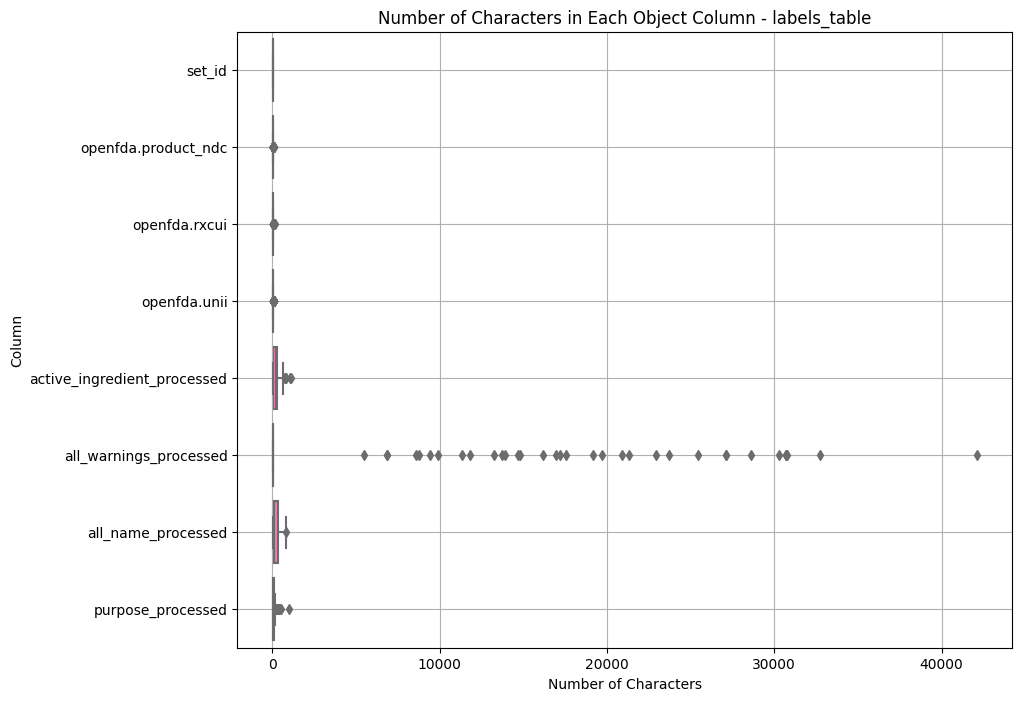


Descriptive Statistics on Character Length:
                             count         mean          std   min   25%  \
set_id                       225.0    36.000000     0.000000  36.0  36.0   
openfda.product_ndc          225.0    15.760000    13.332131   3.0  13.0   
openfda.rxcui                225.0    10.115556    13.902883   3.0   3.0   
openfda.unii                 225.0    22.764444    21.761544   3.0  14.0   
active_ingredient_processed  225.0   205.995556   178.772813   4.0  41.0   
all_warnings_processed       225.0  3029.897778  7909.730056   3.0   3.0   
all_name_processed           225.0   192.275556   205.267497   3.0  13.0   
purpose_processed            225.0    66.520000   102.819801   4.0   4.0   

                               50%    75%      max  
set_id                        36.0   36.0     36.0  
openfda.product_ndc           13.0   13.0     91.0  
openfda.rxcui                  3.0   11.0    154.0  
openfda.unii                  14.0   28.0    112.0  
activ

In [61]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [62]:
labels_table_text_processed_outliers = examine_text_outliers(labels_table['all_warnings_processed'])
print(labels_table_text_processed_outliers.iloc[2])

IndexError: single positional indexer is out-of-bounds

### Rename Columns

In [63]:
labels_table = labels_table.rename(columns = {'openfda.product_ndc': 'ndc',
                                              'openfda.rxcui': 'rxcui',
                                              'openfda.unii': 'unii',
                         'active_ingredient_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'all_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

### Convert Lists to Text

In [64]:
columns_to_convert = ['ndc', 'rxcui', 'ingredients', 'drug_names', 'purpose', 'warnings']


#FUNCTION HAS BEEN MOVED TO FUNCTIONS FILE
# def list_to_string(lst):
#     if isinstance(lst, list):
#         return ', '.join(lst)
#     else:
#         return lst  # Handle non-list values if any

# Apply function to convert lists to strings for each column
for col in columns_to_convert:
    labels_table[col] = labels_table[col].apply(list_to_string)


NameError: name 'list_to_string' is not defined

In [ ]:
labels_table.head()

In [ ]:
labels_table.info()

In [ ]:
# Write the DataFrame to a CSV file
#labels_table.to_csv('DataLibrary/labels_table.csv', index=False)

## PreProcess Events Table

In [ ]:
events_df.info()

#### Select Columns

In [ ]:
events_table = pd.DataFrame(events_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        #"primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        "seriousnessdeath", # 1 = death,
                                       "seriousnessdisabling",  # 1 = disabled
                                       "seriousnessother",  # 1 = other
                                       "seriousnesshospitalization",  # 1 = hospitalized
                                       "seriousnesslifethreatening",  # 1 = life threatening
                                       "duplicate",  # Duplicate status
                                       #"reportduplicate.duplicatesource",  # source of duplicate report
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "occurcountry", # country of the reporter of this event
                                        #"patient.patientonsetage", # age of patient when event occured
                                        #"patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        #"patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                        "patient"]) # Dictionary list - expanded as seperate table
                                        #"patient.drug"]) # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      

In [ ]:
events_table['transmissiondate'].head()

In [ ]:
events_table['transmissiondate'].head()

#### Fix Dtypes

In [ ]:
# Fix date formatting, remove last two characters from each string, FIX THIS
def remove_date_chars(text):
    if isinstance(text, str):
        # Remove punctuation
        text = re.sub(f'.0', '', text)

events_table['transmissiondate'] = events_table['transmissiondate'].apply(remove_date_chars)
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')
# Convert Date to Year
events_table['year'] = events_table['transmissiondate'].dt.year

#events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

#events_table['duplicate'].replace({np.nan: None}, inplace=True)
#events_table['duplicate'] = events_table['duplicate'].astype(pd.Int64Dtype())

#events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
#events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

#events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

#events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

#events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())


### Standardize Age - MOVE TO PATIENT TABLE

In [ ]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(1)

### Feature Engineering

In [ ]:
events_table = add_sequential_index(events_table,'event_id')

#### Combining Levels of Seriousness into 3-Level Variable (death, serious, non-serious)

In [ ]:
# Serious prior to mapping
events_table['serious'].value_counts()

In [ ]:
# Update seriousness categories into three levels
events_table['seriousnessdeath']=events_table['seriousnessdeath'].replace({'2': '0'}).fillna('0').astype(str)
events_table['seriousnessdisabling']=events_table['seriousnessdisabling'].replace({'2': '0', '1': '2'}).fillna('0').astype(str)
events_table['seriousnesshospitalization']=events_table['seriousnesshospitalization'].replace({'2': '0', '1': '3'}).fillna('0').astype(str)
events_table['seriousnesslifethreatening']=events_table['seriousnesslifethreatening'].replace({'2': '0', '1': '4'}).fillna('0').astype(str)
events_table['seriousnessother']=events_table['seriousnessother'].replace({'2': '0', '1': '5'}).fillna('0').astype(str)
events_table['serious'] = events_table['serious'].replace({'2': '6', '1': '0'}).astype(str)

In [ ]:
events_table['seriousnessdeath'].value_counts()

In [ ]:
events_table['seriousnessdisabling'].value_counts()

In [ ]:
events_table['seriousnesshospitalization'].value_counts()

In [ ]:
events_table['seriousnesslifethreatening'].value_counts()

In [ ]:
events_table['seriousnessother'].value_counts()

In [ ]:
events_table['serious'].value_counts()

In [ ]:
# String pattern denoting outcome
events_table['serious_outcome'] = events_table[['seriousnessdeath',
                                                'seriousnessdisabling',
                                                'seriousnesshospitalization',
                                                'seriousnesslifethreatening',
                                               'seriousnessother',
                                               'serious']].sum(axis=1)

In [ ]:
# If string contains "1" - ultimately death, if any number 2-5 - serious, else non-serious
events_table['serious_outcome'] = events_table['serious_outcome'].apply(lambda x: 0 if x == "000006" else 2 if "1" in x else 1)

In [ ]:
events_table['serious_outcome'] = events_table['serious_outcome'].replace({2: 'Death', 1: 'Serious', 0: 'NonSerious'})

In [ ]:
events_table['serious_outcome'].value_counts()

In [ ]:
events_table['serious_outcome'].value_counts(normalize = True)

### Check for Report Duplicates - openFDA return only most recent report

In [ ]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

In [ ]:
events_table[['safetyreportid', 'safetyreportversion', 'duplicate', 'reportduplicate.duplicatesource']].head(5)

### Examine and Handle Nulls

In [ ]:
events_nan = nan_info(events_table)
events_nan

In [ ]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports
* Verify that API called only most recent version of reports

In [ ]:
# Drop NaN values in 'primarysource.qualification'
events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

events_table.shape

In [ ]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

### Rename Columns

In [ ]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.patientonsetage': 'age',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    'transmissiondate': 'event_year',
    'fulfillexpeditecriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

In [ ]:
#pd.reset_option('display.max_colwidth')
events_table.head()

In [ ]:
events_table.info()

### Make new table for PatientDrugs - nested dataframe

#### Without MultiProcessing

In [ ]:
start_time = time.time()

expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [ ]:
start_time = time.time()
expanded_patient_drugs = []
def process_row(row):
    expanded_patient_drugs = []
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'drug' list
    for drug_entry in row['drug']:
        flattened_entry = json_normalize(drug_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_drugs.append(flattened_entry)
    
    return pd.concat(expanded_patient_drugs, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores
    with mp.Pool(num_cores) as pool:
        patient_drugs_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_drugs_table = pd.concat(patient_drugs_list, ignore_index=True)
    patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Make new table for PatientReactions

#### Without MultiProcessing

In [ ]:
start_time = time.time()

expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [ ]:
start_time = time.time()

def process_row(row):
    expanded_patient_reaction = []
    event_id = row['event_id']
    
    # Iterate through each reaction entry in 'reaction' list
    for reaction_entry in row['reaction']:
        flattened_entry = json_normalize(reaction_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_reaction.append(flattened_entry)
    
    return pd.concat(expanded_patient_reaction, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores

    with mp.Pool(num_cores) as pool:
        # Use pool.map to process each row in parallel
        patient_reactions_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_reactions_df = pd.concat(patient_reactions_list, ignore_index=True)
    patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]
    
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Remove Drug and Reaction Columns as they are in new tables

In [ ]:
events_table.drop(['drug', 'reaction'], axis=1, inplace=True)

### Assess Text Field Lengths

In [ ]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [ ]:
events_table_text_processed_outliers = examine_text_outliers(events_table['company'])
print(events_table_text_processed_outliers.iloc[2])

#### Custom Text Processing of Company Information - Retain Name Only

In [ ]:
# Creat list of country abbreviations and extra abbreviations to remove from text data
country_codes = events_table['country'].unique().tolist()
country_codes = [i.lower() for i in country_codes]
country_codes = ['cn' if country == 'canada' else country for country in country_codes]
country_codes = country_codes+["usa", "isr", "ger", "tus", "dklu", "bp", "sp",
                                  "nj", "aus", "deuct", "ve", "pomal", "gbr",
                                  "jacan", "fra", "deu", 'deuct', 'ita',
                              'gw', 'jet', 'aur', 'aut', 'ml',
                              'eut', 'ent', 'sp', 'chn',
                              'jpn', 'kor', 'can', 'europe',
                              'bw', 'rr', 'eu', 'bl', 'deusp',
                              'uki', 'japan', 'teu', 'ind']

extra_abv = ['nldsp', 'usasp', 'company', 'bax', 'spo',
                'ccaza', 'cinry', 'and', 'cansp', 'oxyc',
            'scpr', 'gbrct', 'gbrsp', 'tjp', 'unk',
            'frasp', 'brasp', 'sol', 'cbst','pmco',
            'jpnct', 'frua', 'espct', 'pre',
            'dsu', 'gmbh', 'dse', 'belsp', 'crisp',
            'kdl', 'irlsp', 'mpi', 'avee', 'usani', 
            'sun', 'belct', 'itasp', 'hkgsp', 'argsp']

country_codes_df = pd.DataFrame({'codes': country_codes})

# save list of country codes
country_codes_df.to_csv('DataLibrary/country_codes.csv', index=False)

##### No Multiprocessing

In [ ]:
start_time = time.time() 
events_table['company_name'] = events_table['company'].astype(str).apply(process_company_text)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

##### With Multiprocessing

In [ ]:
# Create a pool with the same number of workers as CPU cores
start_time = time.time() 
if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        company_name = pool.map(process_company_text, events_table['company'])
        events_table['company_name'] = company_name
    # Apply the process_company_row function to each element in the 'company' column in parallel
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
events_table[['company', 'company_name', 'country']].head(20) 

In [ ]:
# Set display option to show the full list without truncation
pd.set_option('display.max_rows', None)
events_table['company_name'].value_counts()
# Reset display option to default
#pd.reset_option('display.max_rows')

#### Text Processing of Country Name

In [ ]:
# Replace category missing label with NA and Canada
events_table['country'] = events_table['country'].replace({"COUNTRY NOT SPECIFIED": pd.NA, "CANADA": 'CN'})

# Lower case country code text
events_table['country'] = events_table['country'].apply(lambda x: x.lower() if pd.notna(x) else x)

In [ ]:
events_table['country'].head(20)

In [ ]:
# Drop Cryptic company information
events_table.drop(['company'], axis = 1, inplace = True)

In [ ]:
events_table[['company_name', 'country']].head(10) 

### Reeaxmine Field Lengths

In [ ]:
plot_character_length(events_table, 'events_table')

In [ ]:
examine_text_outliers(events_table['company_name']).iloc[0:10]

#### Choose Final List of Features

In [ ]:
events_table = events_table[['event_id',
                            'year',
                            'expedited',
                            'report_source',
                            'country',
                            'age',
                            'sex',
                            'serious_outcome',
                            'company_name']]

### Convert Lists to Text

In [ ]:
# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

events_table['company_name'] = events_table['company_name'].apply(list_to_string)
#events_table = events_table.drop(columns=['safetyreportversion'])


events_table = events_table.rename(columns={'event_year': 'year'})

In [ ]:
# Write the DataFrame to a CSV file
events_table.to_csv('DataLibrary/events_table.csv', index=False)

## PreProcess Patient Drugs Table

In [ ]:
patient_drugs_table.head()
patient_drugs_table.columns

#### Select Columns

In [ ]:
patient_drugs_table = pd.DataFrame(patient_drugs_table, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                #'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [ ]:
patient_drugs_table.head(5)

#### Fix Dtypes

In [ ]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [ ]:
patient_drugs_table['drugcharacterization'].value_counts()

In [ ]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [ ]:
patient_drugs_table['drugcharacterization'].value_counts()

### Examine Nulls

In [ ]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

### Text Processing

#### Without MultiProcessing

In [ ]:
# Apply the clean_text function
start_time = time.time()

patient_drugs_table['manu_list'] = patient_drugs_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [ ]:
start_time = time.time()
if __name__ == '__main__':    
    with mp.Pool(num_cores) as pool:
        # Use pool.map to apply clean_manufacturer_text to each element in parallel
        patient_drugs_table['manu_list'] = pool.map(clean_manufacturer_text, patient_drugs_table['openfda.manufacturer_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
# Count the number of manufacturers that produce the drug
patient_drugs_table['manu_num'] = patient_drugs_table['manu_list'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [ ]:
# Count the number of rxcui associated with drug
patient_drugs_table['rxcui_num'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [ ]:
patient_drugs_table[['openfda.manufacturer_name', 'manu_list', 'manu_num', 'rxcui_num']].head(10)

### Cleaning Text Columns

In [ ]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 
                                      'openfda.rxcui', 
                                      'openfda.manufacturer_name', 
                                      'manu_list',
                                     'openfda.spl_set_id'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

#### No multiprocessing

In [ ]:
# Apply the clean_text function
start_time = time.time()

for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Use multiprocessing to process text columns

In [ ]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
# Create a pool with the same number of workers as CPU cores

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = pool.map(process_label_text, patient_drugs_table[col])


### Final list of features for Patient Drugs Table

In [ ]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                           'openfda.spl_set_id',
                                          #'drugcharacterization',  # Not necessary since table is filtered to value of 1 for all
                                          'drugindication_processed',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'manu_list',
                                          'manu_num',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                           'rxcui_num',
                                          'openfda.unii'
                                          ]]

### Rename Columns

In [ ]:
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct_processed': 'med_product',
    'drugindication_processed': 'indication',
    'openfda.generic_name_processed': 'generic_name',
    'manu_list': 'manufacturers',
    'openfda.product_type_processed': 'product_type',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii',
    'openfda.spl_set_id': 'spl_set_id'
})

In [ ]:
patient_drugs_table.info()

### Assess Text Field Lengths

In [ ]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

**Examine 'Manufacturer' Outliers**
Reports contain manufacturers, distributors, and retail

In [ ]:
patient_drugs_table_manufacturer_outliers = examine_text_outliers(patient_drugs_table['manufacturers'])
print(patient_drugs_table_manufacturer_outliers.iloc[2])

**Examine 'rxcui' outliers**

In [ ]:
patient_drugs_table_rxcui_outliers = examine_text_outliers(patient_drugs_table['rxcui'])
print(patient_drugs_table_rxcui_outliers.iloc[1])

#### Convert Lists to Text

In [ ]:
columns_to_convert = ['indication', 'med_product', 'manufacturers','generic_name', 'product_type', 'rxcui', 'unii']

for col in columns_to_convert:
    patient_drugs_table[col] = patient_drugs_table[col].apply(list_to_string)


In [ ]:
# Write the DataFrame to a CSV file
#patient_drugs_table.to_csv('DataLibrary/drugs_table.csv', index=False)

## PreProcess Patient Reactions Table

### Rename Columns

In [ ]:
patient_reactions_table = patient_reactions_df.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [ ]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [ ]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

### Map Features

In [ ]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered',
    2: 'Recovering',
    3: 'NotRecovered',
    4: 'RecoveredWithSequelae',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

## LIST OF UNIQUE REACTIONS

In [ ]:
# Get unique values from the 'reaction' column
unique_reactions = patient_reactions_table['reaction'].unique().tolist()
unique_reactions = [reaction.lower() for reaction in unique_reactions]

# Display unique values
#print(unique_reactions)



### Save each reaction as binary column

In [ ]:
for reaction in unique_reactions:
    patient_reactions_table[reaction] = 0

# Set the value to 1 if 'reaction' matches the column name
for idx, row in patient_reactions_table.iterrows():
    patient_reactions_table.loc[idx, reaction] = 1

patient_reactions_table.head()

In [ ]:
patient_reactions_table.shape

### Text Processing

#### Without MultiProcessing

In [ ]:
#patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

#### With MultiProcessing

In [ ]:
if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        patient_reactions_table['reaction_processed'] = pool.map(process_label_text, patient_reactions_table['reaction'])

#### Drop unprocessed reaction columns

In [ ]:
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [ ]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


### Filter for Data Quality

In [ ]:
# Count the frequency of each category
category_counts = patient_reactions_table['outcome'].value_counts()

# Calculate the percentages
total = len(patient_reactions_table)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

In [ ]:
patient_reactions_table['outcome'].value_counts()

In [ ]:
patient_reactions_table['outcome'].value_counts(normalize=True)

In [ ]:
# Drop cases with "unknown" outcomes
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['outcome'] != 'Unknown']

### Assess Text Field Lengths

In [ ]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [ ]:
reactions_table_text_processed_outliers = examine_text_outliers(patient_reactions_table['reaction_processed'])
print(reactions_table_text_processed_outliers)

In [ ]:
# Write the DataFrame to a CSV file
#patient_reactions_table.to_csv('DataLibrary/reactions_table.csv', index=False)

## PreProcess Prices Table

### Select Columns

In [ ]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        #"Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        #"Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


### Fix Dtypes

In [ ]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
prices_table['year'] = prices_table['Effective Date'].dt.year
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

### Examine Nulls

In [ ]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

### Feature Engineering 

In [ ]:
prices_table['Classification_for_Rate_Setting'].value_counts()

In [ ]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [ ]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')

### Rename Columns

In [ ]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [ ]:
prices_table = prices_table[['ndc',
                            'unit_price',
                            'year',
                            'generic_brand']]

In [ ]:
prices_table.info()

In [ ]:
# Write the DataFrame to a CSV file
#prices_table.to_csv('DataLibrary/prices_table.csv', index=False)

## Preprocess Documents Table

### Select Columns

In [ ]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')


### Fix Dtypes

### Match Drugs Present in Text

In [ ]:
def find_matching_drugs(text, unique_drug_names):
    matched_drugs = []
    for drug in unique_drug_names:
        if drug.lower() in text.lower():
            matched_drugs.append(drug)
    return matched_drugs


#### Without MultiProcessing

In [ ]:
start_time = time.time()
# Create 'matching_drugs' column using apply
documents_table['matching_drugs'] = documents_table['text'].apply(lambda x: find_matching_drugs(x, unique_drug_names))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [ ]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores

start_time = time.time()


if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        documents_table['matching_drugs'] = pool.starmap(find_matching_drugs, zip(documents_table['text'], [unique_drug_names]*len(documents_table)))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

### Match Reactions Present in Text

In [ ]:
# Function to check for matches between text and unique_reactions
def check_reactions(text, unique_reactions):
    text_lower = text.lower()
    matches = [1 if reaction.lower() in text_lower else 0 for reaction in unique_reactions]
    return matches

In [ ]:
documents_table.head()

### Generate binary column for each reaction

In [ ]:
# Apply the function across the dataframe to populate binary columns
documents_table[unique_reactions] = documents_table['text'].apply(lambda x: pd.Series(check_reactions(x, unique_reactions)))

# Text column no longer needed
documents_table.drop(columns=['text'], inplace=True)

# Function to return matching reactions as a list
def get_matching_reactions(row, unique_reactions):
    matching_reactions = [reaction for reaction in unique_reactions if row[reaction] == 1]
    return matching_reactions

# Create 'all_reactions' column by applying the function row-wise
documents_table['all_reactions'] = documents_table.apply(lambda row: get_matching_reactions(row, unique_reactions), axis=1)

documents_table.head()

In [ ]:
# apply parallel processing

### Explode Table by Reaction 

In [ ]:
# Explode the dataframe based on reaction; makes a new row for each reaction in the list
documents_table = documents_table.explode('matching_drugs').reset_index(drop=True)

### Rename columns

In [ ]:
documents_table.rename(columns={'matching_drugs': 'drug'}, inplace=True)
documents_table.head()

### Fix Dtypes

In [ ]:
numeric_columns = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug'])
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN

In [ ]:
documents_table.dtypes

### Drop all reactions column

In [ ]:
documents_table.drop(columns=['all_reactions'], inplace=True)


### Add new additional id column

In [ ]:
documents_table.head()
documents_table = add_sequential_index(documents_table, 'id')

### Save as CSV for Data Exploration

In [ ]:
documents_table.to_csv('documents_table.csv', index=False)


## Preprocess Manufacturers Table

In [ ]:
manus_df.columns

### Select Columns

In [ ]:
# Choose values to help fill in missing data from other tables
manus_table = pd.DataFrame(manus_df, 
                           columns=["product_ndc",
                                    "generic_name",
                                    "brand_name",
                                    "openfda.manufacturer_name",
                                   "spl_id",
                                   "openfda.spl_set_id",
                                   "openfda.unii",
                                   "marketing_start_date"])

### Feature Engineering

In [ ]:
manus_table = add_sequential_index(manus_table,'manu_id')

In [ ]:
manus_table['year'] = pd.to_datetime(manus_table['marketing_start_date']).dt.year

### Examine Nulls

In [ ]:
manus_nan = nan_info(manus_table)
manus_nan

### Fix Dtypes

### Text Processing

In [ ]:
manus_table['drug_names'] = manus_table['generic_name']+ " " + manus_table['brand_name']

In [ ]:
manus_table['drug_names_processed'] = manus_table['drug_names'].apply(process_label_text).apply(remove_duplicates_nan)
manus_table[['drug_names', 'drug_names_processed']].head(10)

In [ ]:
manus_table['manufacturers'] = manus_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)
manus_table[['openfda.manufacturer_name', 'manufacturers']].head(10)

In [ ]:
manus_table_rxcui_outliers = examine_text_outliers(manus_table['manufacturers'])
print(manus_table_rxcui_outliers)

### Rename and Select Columns

In [ ]:
manus_table = manus_table.rename(columns = {'product_ndc': 'ndc',
                         'drug_names_processed': 'drug_names',
                         'openfda.spl_set_id': 'set_id',
                         'openfda.unii': 'unii'})

In [ ]:
manus_table = manus_table[['manu_id',
                           'spl_id',
                           'ndc',
                           'year',
                          'drug_names',
                          'set_id',
                          'unii',
                           'drug_names',
                          'manufacturers']]

### Assess Text Field Lenghts

In [ ]:
plot_character_length(manus_table, 'manus_table')

In [ ]:
# Write the DataFrame to a CSV file
#manus_table.to_csv('DataLibrary/manus_table.csv', index=False)

# Standardization and Normalization
* Use Parallel Processing

## Read in ADReCS Files

In [ ]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

In [ ]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

## Standardize Drug Names into Primary Ingredient Compounds
* Based on 90% string match between FAERS reported medicinal product and ADReCS classification data

In [ ]:
# Reactions table test set
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:80, ]
drugs_test

In [ ]:
from pathos.multiprocessing import ProcessingPool as Pool
import pandas as pd
import numpy as np
import multiprocessing as mp
from fuzzywuzzy import process
import time

In [ ]:
def process_and_normalize_drugs(df_chunk, df2_synonyms, df2_names):
    def drug_name_norms(row):
        med_product_list = str(row['med_product']).split(' \, ')
        med_product_list = list(set(med_product_list))  # unique values
        synonyms_list = list(set(' '.join(df2_synonyms).split(' \| ')))  # unique values
        match = process.extractOne(' '.join(med_product_list), synonyms_list)
        if match and match[1] > 90:
            original_row_index = df2_synonyms[df2_synonyms.str.contains(match[0], regex=False)].index
            if not original_row_index.empty:
                return df2_names.iloc[original_row_index[0]]
        return None

    df_chunk['drug_name_norm'] = df_chunk.apply(drug_name_norms, axis=1)
    return df_chunk

def parallel_worker(chunk, func, args):
    return func(chunk, *args)

def apply_parallel(df, func, args):
    df_split = np.array_split(df, mp.cpu_count())
    with mp.Pool(mp.cpu_count()) as pool:
        result = pd.concat(pool.starmap(parallel_worker, [(chunk, func, args) for chunk in df_split]))
    return result

if __name__ == '__main__':

    start_time = time.time()

    # Apply the parallel processing
    result_table = apply_parallel(drugs_test, process_and_normalize_drugs, (adrecs_drugs['DRUG_SYNONYMS'], adrecs_drugs['DRUG_NAME']))

    # Combine the result into a single column in the original table
    drugs_test['drug_name_norm'] = result_table['drug_name_norm']

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

In [ ]:
drugs_test[['med_product', 'drug_name_norm']].head(10)

## Standardize Adverse Event Terms
* Based on an 80% string match with ADReCS ontology system

In [ ]:
# Reactions table test set
#reactions_test = pd.read_csv('DataLibrary/reactions_table.csv').iloc[0:5, ]
#reactions_test

In [ ]:
# Time Processing
#start_time = time.time()

# Function to find the best match and return the corresponding value
#def drug_adr_norms(row, df2_col2, df2_col3):
    # Ensure that med_product is a string
#    reaction_processed = str(row['reaction_processed'])
    # Split the synonyms and create a list
#    synonyms_list = df2_col2.str.split(' \| ').explode().unique()
    # Find the best match
#    match = process.extractOne(reaction_processed, synonyms_list)
#    if match and match[1] > 80:  # 80 is a threshold for matching confidence
        # Find the original row in df2_col2
#        original_row = df2_col2[df2_col2.str.contains(match[0], regex=False)]
#        if not original_row.empty:
#            return df2_col3[original_row.index[0]]
#    return None


# Apply the function to df1 to create the new column
#reactions_test['adr_norm'] = reactions_test.apply(drug_adr_norms, 
#                                                             args=(adrecs_ont['ADR_SYNONYMS'], 
#                                                                   adrecs_ont['ADR_TERM']), axis=1)

#end_time = time.time()
#execution_time = end_time - start_time
#print(execution_time)

## Filling in Missing Data Across Tables

#### Create Smaller Samples for Testing 

In [ ]:
labels_test = pd.read_csv('DataLibrary/labels_table.csv').iloc[0:50,]
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:50,]

#### Remove punctuation from set_id, ndc codes, unii, to standardize across tables

In [ ]:
# Function to standardize NDC format
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))


# Apply to both dataframes
labels_test['ndc'] = labels_test['ndc'].astype(str).apply(remove_punctuation)
manus_table['ndc'] = manus_table['ndc'].astype(str).apply(remove_punctuation)
labels_test['set_id'] = labels_test['set_id'].astype(str).apply(remove_punctuation)
manus_table['set_id'] = manus_table['set_id'].astype(str).apply(remove_punctuation)


#### Check for matching NDC codes across sources

In [ ]:
def find_matches(list1, list2):

     # Convert inner lists to tuples to make them hashable
    set1 = set(tuple(x) if isinstance(x, list) else x for x in list1)
    set2 = set(tuple(x) if isinstance(x, list) else x for x in list2)
    
    # Find the intersection of the two sets
    common_elements = set1.intersection(set2)
    
    # Convert the set back to a list
    return list(common_elements)

list1 = manus_table['set_id'].tolist()
list2 = labels_test['set_id'].tolist()

matches = find_matches(list1, list2)
matches

### Manufacturer Table Contains 100% of NDC code for all actively marketed drugs
* Create dictionary pairs to map and fill in missing data for dictionary method

In [ ]:
# Fill in missing unii and spl_set_id with zeros to create dictionaries
manus_table['unii'] = manus_table['unii'].fillna(0)
manus_table['set_id'] = manus_table['set_id'].fillna(0)

In [ ]:
# Dictionary of ndc and spl_id
manu_ndc_spl_dict = dict(zip(manus_table['ndc'], manus_table['spl_id']))

In [ ]:
# Dictionary of ndc code and unii
manu_ndc_unii_dict = dict(zip(manus_table['ndc'], manus_table['unii']))

In [ ]:
# Dictionary of ndc code and spl_set_id
manu_ndc_set_dict = dict(zip(manus_table['ndc'],manus_table['set_id']))

### Using String Match Function Across DataFrames to Fill in Missing Data 

In [ ]:
# Data Prior to matching
labels_test.info()

In [ ]:
labels_test

In [ ]:
# Define string-match function
def match_ndc(df1, df2, df1_col1, df1_col2, df2_col1, df2_col2):
    def find_match(row):
        if row[df1_col1] == 'nan':
            set_id = row[df1_col2]
            match = process.extractOne(set_id, df2[df2_col2].astype(str).tolist())
            if match and match[1] == 90:  # 90 is a threshold for matching confidence
                matched_row = df2[df2[df2_col2].astype(str) == match[0]]
                if not matched_row.empty:
                    ndc_value = matched_row[df2_col1].values[0]
                    # If ndc_value is a list, return the first element, otherwise return the string
                    if isinstance(ndc_value, list):
                        return ndc_value[0]
                    else:
                        return ndc_value
        return row[df1_col1]
    
    df1[df1_col1] = df1.apply(find_match, axis=1)
    return df1

# Start timing
start_time = time.time()

# Using the function to fill in missing ndc values in df1
labels_test = match_ndc(labels_test, manus_table, 'ndc', 'set_id', 'ndc', 'set_id')

# End timing
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

In [ ]:
# Check if data was filled in post-matching
labels_test.info()

In [ ]:
labels_test['ndc'].tolist()

In [ ]:
# Look up specific set_ids and ndc in manus_table to confirm proper matching


### Using Reverse Dictionary Mapping to Fill in Missing Data

In [ ]:
# Examine data before matching
labels_test

In [ ]:
# Time it
start_time = time.time()

# Create reverse mapping from set_id to ndc
reverse_mapping = {}
for ndc, set_ids in manu_ndc_set_dict.items():
    if isinstance(set_ids, list):
        for set_id in set_ids:
            reverse_mapping[set_id] = ndc

# Function to fill NaN values in 'ndc' based on 'set_id'
def fillna_ndc_with_setid(row, reverse_dict):
    if pd.isna(row['ndc']) and row['set_id'] in reverse_dict:
        return reverse_dict[row['set_id']]
    return row['ndc']

# Apply the function to fill NaN values in 'ndc'
labels_test['ndc'] = labels_test.apply(lambda row: fillna_ndc_with_setid(row, reverse_mapping), axis = 1)

In [ ]:
# Check if data was filled in post-matching
labels_test.info()

In [ ]:
labels_test

In [ ]:
manus_table.head()

In [ ]:
# Look up specific set_ids and ndc in manus_table to confirm proper matching
ndc_check = manus_table.loc[manus_table['set_id'] == "000155a8709c44e5a75fcd890f3a7caf", 'ndc'].values
ndc_check

### Using a Random Forest Classifier to "Predict" Missing Data
* Train on Full NDC/SET_ID List, Test Predict Missing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
# Time it
start_time = time.time()

# Ensure all columns are strings
manus_table['ndc'] = manus_table['ndc'].astype(str)
manus_table['set_id'] = manus_table['set_id'].astype(str)
labels_test['set_id'] = labels_test['set_id'].astype(str)
labels_test['ndc'] = labels_test['ndc'].astype(str)

# Encode ndc in manus_table
le = LabelEncoder()
manus_table['ndc_encoded'] = le.fit_transform(manus_table['ndc'])

# TF-IDF vectorization for set_id
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(manus_table['set_id'])
X_test_tfidf = vectorizer.transform(labels_test['set_id'])

# Convert to DataFrame for alignment with other columns
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Align test set with train set
X_test_tfidf = X_test_tfidf.reindex(columns=X_train_tfidf.columns, fill_value=0)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, manus_table['ndc_encoded'])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
# Predict missing ndc values
start_time = time.time()

y_pred_encoded = model.predict(X_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded)

# Fill the missing ndc values in the original dataframe
labels_test['ndc'] = labels_test.apply(lambda row: y_pred[list(labels_test.index).index(row.name)] if pd.isnull(row['ndc']) else row['ndc'], axis=1)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

In [ ]:
# Before
labels_test[['set_id', 'ndc']]

In [ ]:
# After
labels_test[['set_id', 'ndc']]

In [ ]:
# search manus_table to confirm 

### Generate Year Helper Table

In [ ]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})

# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [ ]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [ ]:
# public username and password

### Create Edit Privelages for Us

In [ ]:
# private username and password

## Create datframes from API request dataframes

In [ ]:
documents_table.head()


In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

#--------------------------------------------------------------------------

#Create year table
create_year_query = """
CREATE TABLE IF NOT EXISTS `year` (
  `year` INT(4),
  PRIMARY KEY (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_year_query)


# Create documents table

# Define specific columns and their data types
documents_specific_columns = {
    'id': 'INT NOT NULL',
    'doc_id': 'INT NOT NULL',
    'doc_type': 'VARCHAR(4)',
    'year': 'INT(4)',
    'drug': 'VARCHAR(100)'
}

# Generate column definitions for unspecified columns as BOOLEAN
column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in documents_table.columns if col not in documents_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_documents_table_query = f"""
CREATE TABLE IF NOT EXISTS `documents` (
  {", ".join([f"`{col}` {documents_specific_columns.get(col, 'BOOL')}" for col in documents_table.columns])},
  PRIMARY KEY(`id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""

cursor.execute(create_documents_table_query)
#----------------------------------------------------------------------
# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT,
  `safetyreportid` VARCHAR(9),
  `year` INT(4),
  `serious_outcome` VARCHAR(10),
  `expedited` BOOLEAN,
  `report_source` INT,
  `country` VARCHAR(25),
  `age` INT,
  `sex` INT,
  `company_name` VARCHAR(200),
  PRIMARY KEY (`event_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table ------------------------

# Define specific columns and their data types

patient_reactions_specific_columns = {
 'patient_reaction_id': 'INT NOT NULL',
  'event_id' : 'INT',
  'version_medRNA' : 'VARCHAR(4)',
  'outcome': 'VARCHAR(50)'
}
  
#Generate column definitions for unspecified columns as BOOLEAN
patient_reactions_column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in patient_reactions_table.columns if col not in patient_reactions_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_patient_reactions_query = f"""
CREATE TABLE IF NOT EXISTS `patient_reactions` (
  {", ".join([f"`{col}` {patient_reactions_specific_columns.get(col, 'BOOL')}" for col in patient_reactions_table.columns])},
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""

cursor.execute(create_patient_reactions_query)

#-------------------------------------------

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(200), 
  `rxcui` VARCHAR(200),
  `label_date` DATE,
  `ingredients` VARCHAR(5000),
  `warnings` TEXT(20000),
  `drug_names` VARCHAR(7500),
  `purpose` VARCHAR(2200),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table

#temporarily removed on delete cascade foreign key constraint for event_id for troubleshooting
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(250),
  `indication` VARCHAR(150),
  `generic_name` VARCHAR(300),
  `manufacturers` VARCHAR(5000),
  `manu_num` INT,
  `product_type` VARCHAR(100),
  `rxcui` VARCHAR(760),
  `rxcui_num` INT,
  `unii` VARCHAR(150),
  PRIMARY KEY(`patient_drug_id`),
  INDEX(`event_id`),
  INDEX(`rxcui`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `year` INT(4),
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)


# Create drug_names table
create_drug_names_query = """
CREATE TABLE IF NOT EXISTS `drug_names` (
  `drug_name_id` INT NOT NULL AUTO_INCREMENT,
  `label_id` INT,
  `rxcui` VARCHAR(100),
  `ndc` VARCHAR(60),
  `ingredients` VARCHAR(1000),
  PRIMARY KEY(`drug_name_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`),
  FOREIGN KEY (`ndc`) REFERENCES `prices` (`ndc`),
  FOREIGN KEY (`rxcui`) REFERENCES `patient_drugs` (`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_drug_names_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

## Bulk Import Data from Dataframes

### Year Table

#### Preview Year Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM year LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Documents Table

#### Import Data

In [ ]:

start_time = time.time()

documents_table.to_sql('documents', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
#documents_table.to_sql('documents', con=connection, if_exists='append', index=False)

#### Preview Documents Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM documents LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Events Table

#### Import Data

In [ ]:
start_time = time.time()

events_table.to_sql('adverse_events', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Preview Events Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM adverse_events LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Patient Drugs Table

#### Set Character Limits

In [ ]:
patient_drugs_table['manufacturers'] = patient_drugs_table['manufacturers'].apply(lambda x: x[:5000] if isinstance(x, str) else x)
patient_drugs_table['rxcui'] = patient_drugs_table['rxcui'].apply(lambda x: x[:760] if isinstance(x, str) else x)

#### Import data

In [ ]:
patient_drugs_table.tail()

In [ ]:
patient_drugs_table.to_sql('patient_drugs', con=engine, if_exists='append', index=False)

#### Preview Drugs Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_drugs LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Patient Reactions Table

In [ ]:
patient_reactions_table.head()
#patient_reactions_table = patient_reactions_table.drop(columns=['reaction_processed'])


In [ ]:
patient_reactions_table.to_sql('patient_reactions', con=engine, if_exists='append', index=False)

#### Preview Patient Reactions Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_reactions LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Labels Table

#### Set Character Limits

In [ ]:
#truncate warnings
labels_table['warnings'] = labels_table['warnings'].apply(lambda x: x[:20000] if isinstance(x, str) else x)
labels_table['ingredients'] = labels_table['ingredients'].apply(lambda x: x[:5000] if isinstance(x, str) else x)


#### Import Data

In [ ]:
start_time = time.time()

labels_table.to_sql('labels', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Preview Labels Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM labels LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

### Prices Table

#### Import Data

In [ ]:
start_time = time.time()

prices_table.to_sql('prices', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Preview Prices Table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM prices LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df